# DataFrames Extras
Some selected functionalities and packages

In [1]:
using DataFrames
using CategoricalArrays

## Frequency Tables
https://github.com/nalimilan/FreqTables.jl

In [2]:
using FreqTables

df = DataFrame(a=rand('a':'d', 1000), b=rand(["x", "y", "z"], 1000))
ft = freqtable(df, :a, :b) ## observe that dimensions are sorted if possible

4×3 Named Matrix{Int64}
a ╲ b │   x    y    z
──────┼──────────────
a     │  81   88   71
b     │  80   90   79
c     │  97  100   74
d     │  74   92   74

you can index the result using numbers or names

In [3]:
ft[1,1], ft['b', "z"]

(81, 79)

getting proportions - 1 means we want to calculate them in rows (first dimension)

In [4]:
prop(ft, margins=1)

4×3 Named Matrix{Float64}
a ╲ b │        x         y         z
──────┼─────────────────────────────
a     │   0.3375  0.366667  0.295833
b     │ 0.321285  0.361446  0.317269
c     │ 0.357934  0.369004  0.273063
d     │ 0.308333  0.383333  0.308333

and columns are normalized to 1.0 now

In [5]:
prop(ft, margins=2)

4×3 Named Matrix{Float64}
a ╲ b │        x         y         z
──────┼─────────────────────────────
a     │ 0.243976  0.237838  0.238255
b     │ 0.240964  0.243243  0.265101
c     │ 0.292169   0.27027  0.248322
d     │ 0.222892  0.248649  0.248322

In [6]:
x = categorical(rand(1:3, 10))
levels!(x, [3, 1, 2, 4]) ## reordering levels and adding an extra level
freqtable(x) ## order is preserved and not-used level is shown

4-element Named Vector{Int64}
Dim1  │ 
──────┼──
3     │ 4
1     │ 2
2     │ 4
4     │ 0

by default missing values are listed

In [7]:
freqtable([1,1,2,3,missing])

4-element Named Vector{Int64}
Dim1    │ 
────────┼──
1       │ 2
2       │ 1
3       │ 1
missing │ 1

but we can skip them

In [8]:
freqtable([1,1,2,3,missing], skipmissing=true)

3-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 2
2     │ 1
3     │ 1

In [9]:
df = DataFrame(a=rand(3:4, 1000), b=rand(5:6, 1000))
ft = freqtable(df, :a, :b) ## now dimensions are numbers

2×2 Named Matrix{Int64}
a ╲ b │   5    6
──────┼─────────
3     │ 256  242
4     │ 263  239

this is an error - standard array indexing takes precedence

In [10]:
try
    ft[3,5]
catch e
    show(e)
end

BoundsError([256 242; 263 239], (3, 5))

you have to use `Name()` wrapper

In [11]:
ft[Name(3), Name(5)]

256

## DataFramesMeta.jl
https://github.com/JuliaData/DataFramesMeta.jl provides a more terse syntax due to the benefits of metaprogramming.

In [12]:
using DataFramesMeta

df = DataFrame(x=1:8, y='a':'h', z=repeat([true,false], outer=4))

8×3 DataFrame
 Row │ x      y     z     
     │ Int64  Char  Bool  
─────┼────────────────────
   1 │     1  a      true
   2 │     2  b     false
   3 │     3  c      true
   4 │     4  d     false
   5 │     5  e      true
   6 │     6  f     false
   7 │     7  g      true
   8 │     8  h     false

expressions with columns of DataFrame

In [13]:
@with(df, :x + :z)

8-element Vector{Int64}:
 2
 2
 4
 4
 6
 6
 8
 8

you can define complex operations code blocks

In [14]:
@with df begin
    a = :x[:z]
    b = :x[.!:z]
    :y + [a; b]
end

8-element Vector{Char}:
 'b': ASCII/Unicode U+0062 (category Ll: Letter, lowercase)
 'e': ASCII/Unicode U+0065 (category Ll: Letter, lowercase)
 'h': ASCII/Unicode U+0068 (category Ll: Letter, lowercase)
 'k': ASCII/Unicode U+006B (category Ll: Letter, lowercase)
 'g': ASCII/Unicode U+0067 (category Ll: Letter, lowercase)
 'j': ASCII/Unicode U+006A (category Ll: Letter, lowercase)
 'm': ASCII/Unicode U+006D (category Ll: Letter, lowercase)
 'p': ASCII/Unicode U+0070 (category Ll: Letter, lowercase)

 `@with` creates hard scope so variables do not leak out

In [15]:
df2 = DataFrame(a = [:a, :b, :c])
@with(df2, :a .== ^(:a)) ## sometimes we want to work on a raw Symbol, ^() escapes it

3-element BitVector:
 1
 0
 0

In [16]:
x_str = "x"
y_str = "y"
df2 = DataFrame(x=1:3, y=4:6, z=7:9)
# $expression inderpolates the expression in-place; in particular this way you can use column names passed as strings
@with(df2, $x_str + $y_str)

3-element Vector{Int64}:
 5
 7
 9

`@subset`: a very useful macro for filtering

In [17]:
@subset(df, :x .< 4, :z .== true)

2×3 DataFrame
 Row │ x      y     z    
     │ Int64  Char  Bool 
─────┼───────────────────
   1 │     1  a     true
   2 │     3  c     true

create a new DataFrame based on the old one

In [18]:
@select(df, :x, :y = 2*:x, :z=:y)

8×3 DataFrame
 Row │ x      y      z    
     │ Int64  Int64  Char 
─────┼────────────────────
   1 │     1      2  a
   2 │     2      4  b
   3 │     3      6  c
   4 │     4      8  d
   5 │     5     10  e
   6 │     6     12  f
   7 │     7     14  g
   8 │     8     16  h

create a new DataFrame adding columns based on the old one

In [19]:
@transform(df, :x = 2*:x, :y = :x)

8×3 DataFrame
 Row │ x      y      z     
     │ Int64  Int64  Bool  
─────┼─────────────────────
   1 │     2      1   true
   2 │     4      2  false
   3 │     6      3   true
   4 │     8      4  false
   5 │    10      5   true
   6 │    12      6  false
   7 │    14      7   true
   8 │    16      8  false

sorting into a new data frame, less powerful than sort, but lightweight

In [20]:
@orderby(df, :z, -:x)

8×3 DataFrame
 Row │ x      y     z     
     │ Int64  Char  Bool  
─────┼────────────────────
   1 │     8  h     false
   2 │     6  f     false
   3 │     4  d     false
   4 │     2  b     false
   5 │     7  g      true
   6 │     5  e      true
   7 │     3  c      true
   8 │     1  a      true

### Chaining operations
https://github.com/jkrumbiegel/Chain.jl :Chaining of operations on DataFrame, could be used with DataFramesMeta.jl

In [21]:
using Chain

@chain df begin
    @subset(:x .< 5)
    @orderby(:z)
    @transform(:x² = :x .^ 2)
    @select(:z, :x, :x²)
end

4×3 DataFrame
 Row │ z      x      x²    
     │ Bool   Int64  Int64 
─────┼─────────────────────
   1 │ false      2      4
   2 │ false      4     16
   3 │  true      1      1
   4 │  true      3      9

### Working on grouped DataFrame

In [22]:
df = DataFrame(a = 1:12, b = repeat('a':'d', outer=3))
g = groupby(df, :b)

GroupedDataFrame with 4 groups based on key: b
First Group (3 rows): b = 'a': ASCII/Unicode U+0061 (category Ll: Letter, lowercase)
 Row │ a      b    
     │ Int64  Char 
─────┼─────────────
   1 │     1  a
   2 │     5  a
   3 │     9  a
⋮
Last Group (3 rows): b = 'd': ASCII/Unicode U+0064 (category Ll: Letter, lowercase)
 Row │ a      b    
     │ Int64  Char 
─────┼─────────────
   1 │     4  d
   2 │     8  d
   3 │    12  d

groupby+combine in one line

In [23]:
using Statistics

@by(df, :b, :first = first(:a), :last = last(:a), :mean = mean(:a))

4×4 DataFrame
 Row │ b     first  last   mean    
     │ Char  Int64  Int64  Float64 
─────┼─────────────────────────────
   1 │ a         1      9      5.0
   2 │ b         2     10      6.0
   3 │ c         3     11      7.0
   4 │ d         4     12      8.0

the same as by but on grouped DataFrame

In [24]:
@combine(g, :first = first(:a), :last = last(:a), :mean = mean(:a))

4×4 DataFrame
 Row │ b     first  last   mean    
     │ Char  Int64  Int64  Float64 
─────┼─────────────────────────────
   1 │ a         1      9      5.0
   2 │ b         2     10      6.0
   3 │ c         3     11      7.0
   4 │ d         4     12      8.0

similar in DataFrames.jl - we use auto-generated column names

In [25]:
combine(g, :a .=> [first, last, mean])

4×4 DataFrame
 Row │ b     a_first  a_last  a_mean  
     │ Char  Int64    Int64   Float64 
─────┼────────────────────────────────
   1 │ a           1       9      5.0
   2 │ b           2      10      6.0
   3 │ c           3      11      7.0
   4 │ d           4      12      8.0

perform operations within a group and return ungrouped DataFrame

In [26]:
@transform(g, :center = mean(:a), :centered = :a .- mean(:a))

12×4 DataFrame
 Row │ a      b     center   centered 
     │ Int64  Char  Float64  Float64  
─────┼────────────────────────────────
   1 │     1  a         5.0      -4.0
   2 │     2  b         6.0      -4.0
   3 │     3  c         7.0      -4.0
   4 │     4  d         8.0      -4.0
   5 │     5  a         5.0       0.0
   6 │     6  b         6.0       0.0
   7 │     7  c         7.0       0.0
   8 │     8  d         8.0       0.0
   9 │     9  a         5.0       4.0
  10 │    10  b         6.0       4.0
  11 │    11  c         7.0       4.0
  12 │    12  d         8.0       4.0

this is defined in DataFrames.jl

In [27]:
DataFrame(g)

12×2 DataFrame
 Row │ a      b    
     │ Int64  Char 
─────┼─────────────
   1 │     1  a
   2 │     5  a
   3 │     9  a
   4 │     2  b
   5 │     6  b
   6 │    10  b
   7 │     3  c
   8 │     7  c
   9 │    11  c
  10 │     4  d
  11 │     8  d
  12 │    12  d

actually this is not the same as DataFrame() as it preserves the original row order

In [28]:
@transform(g)

12×2 DataFrame
 Row │ a      b    
     │ Int64  Char 
─────┼─────────────
   1 │     1  a
   2 │     2  b
   3 │     3  c
   4 │     4  d
   5 │     5  a
   6 │     6  b
   7 │     7  c
   8 │     8  d
   9 │     9  a
  10 │    10  b
  11 │    11  c
  12 │    12  d

### Row-wise operations on DataFrame

In [29]:
df = DataFrame(a = 1:12, b = repeat(1:4, outer=3))

12×2 DataFrame
 Row │ a      b     
     │ Int64  Int64 
─────┼──────────────
   1 │     1      1
   2 │     2      2
   3 │     3      3
   4 │     4      4
   5 │     5      1
   6 │     6      2
   7 │     7      3
   8 │     8      4
   9 │     9      1
  10 │    10      2
  11 │    11      3
  12 │    12      4

such conditions are often needed but are complex to write

In [30]:
@transform(df, :x = ifelse.((:a .> 6) .& (:b .== 4), "yes", "no"))

12×3 DataFrame
 Row │ a      b      x      
     │ Int64  Int64  String 
─────┼──────────────────────
   1 │     1      1  no
   2 │     2      2  no
   3 │     3      3  no
   4 │     4      4  no
   5 │     5      1  no
   6 │     6      2  no
   7 │     7      3  no
   8 │     8      4  yes
   9 │     9      1  no
  10 │    10      2  no
  11 │    11      3  no
  12 │    12      4  yes

one option is to use a function that works on a single observation and broadcast it

In [31]:
myfun(a, b) = a > 6 && b == 4 ? "yes" : "no"
@transform(df, :x = myfun.(:a, :b))

12×3 DataFrame
 Row │ a      b      x      
     │ Int64  Int64  String 
─────┼──────────────────────
   1 │     1      1  no
   2 │     2      2  no
   3 │     3      3  no
   4 │     4      4  no
   5 │     5      1  no
   6 │     6      2  no
   7 │     7      3  no
   8 │     8      4  yes
   9 │     9      1  no
  10 │    10      2  no
  11 │    11      3  no
  12 │    12      4  yes

or you can use `@eachrow` macro that allows you to process DataFrame rowwise

In [32]:
@eachrow df begin
    @newcol :x::Vector{String}
     :x = :a > 6 && :b == 4 ? "yes" : "no"
 end

12×3 DataFrame
 Row │ a      b      x      
     │ Int64  Int64  String 
─────┼──────────────────────
   1 │     1      1  no
   2 │     2      2  no
   3 │     3      3  no
   4 │     4      4  no
   5 │     5      1  no
   6 │     6      2  no
   7 │     7      3  no
   8 │     8      4  yes
   9 │     9      1  no
  10 │    10      2  no
  11 │    11      3  no
  12 │    12      4  yes

In `DataFrames.jl` you would write this as:

In [33]:
transform(df, [:a, :b] => ByRow((a,b) -> ifelse(a > 6 && b == 4, "yes", "no")) => :x)

12×3 DataFrame
 Row │ a      b      x      
     │ Int64  Int64  String 
─────┼──────────────────────
   1 │     1      1  no
   2 │     2      2  no
   3 │     3      3  no
   4 │     4      4  no
   5 │     5      1  no
   6 │     6      2  no
   7 │     7      3  no
   8 │     8      4  yes
   9 │     9      1  no
  10 │    10      2  no
  11 │    11      3  no
  12 │    12      4  yes

You can also use eachrow from DataFrames to perform the same transformation. However `@eachrow` will be faster than the operation below.

In [34]:
df2 = copy(df)
df2.x = Vector{String}(undef, nrow(df2))
for row in eachrow(df2)
   row[:x] = row[:a] > 6 && row[:b] == 4 ? "yes" : "no"
end
df2

12×3 DataFrame
 Row │ a      b      x      
     │ Int64  Int64  String 
─────┼──────────────────────
   1 │     1      1  no
   2 │     2      2  no
   3 │     3      3  no
   4 │     4      4  no
   5 │     5      1  no
   6 │     6      2  no
   7 │     7      3  no
   8 │     8      4  yes
   9 │     9      1  no
  10 │    10      2  no
  11 │    11      3  no
  12 │    12      4  yes

## StatsPlots.jl: Visualizing data
https://github.com/JuliaPlots/StatsPlots.jl
you might want to setup Plots package and some plotting backend first

In [35]:
using StatsPlots

A showcase of StatsPlots.jl functions

In [36]:
using Random
Random.seed!(1)
df = DataFrame(x = sort(randn(1000)), y=randn(1000), z = [fill("b", 500); fill("a", 500)]);

a basic plot

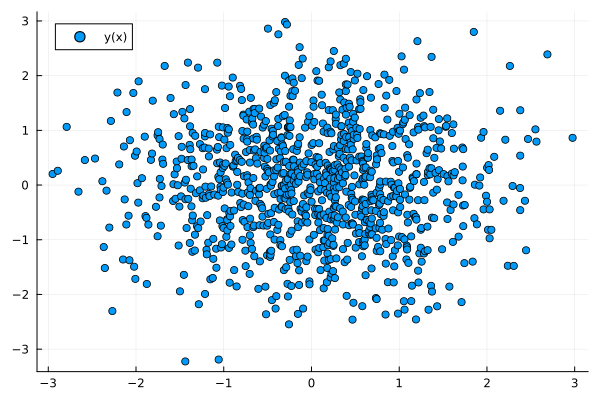

In [37]:
@df df plot(:x, :y, legend=:topleft, label="y(x)", seriestype=:scatter)

a density plot

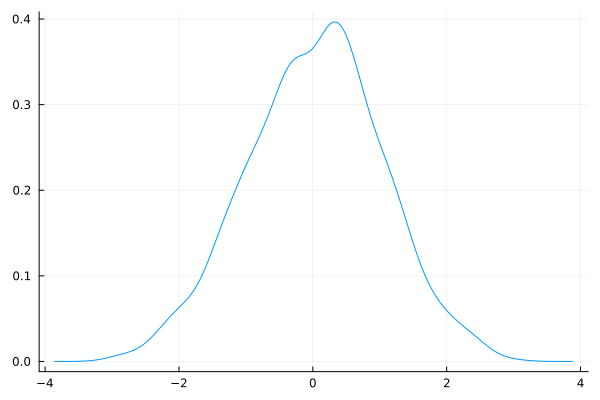

In [38]:
@df df density(:x, label="")

a histogram

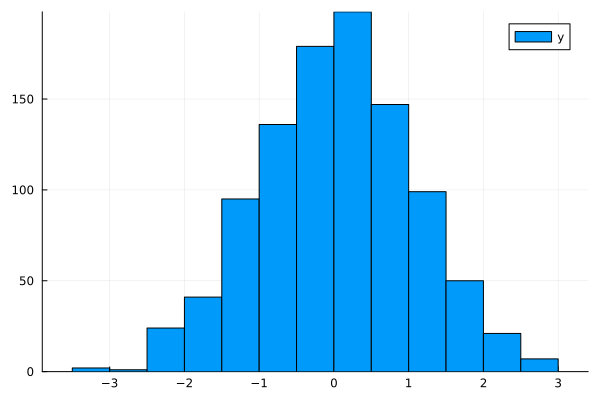

In [39]:
@df df histogram(:y, label="y")

a box plot

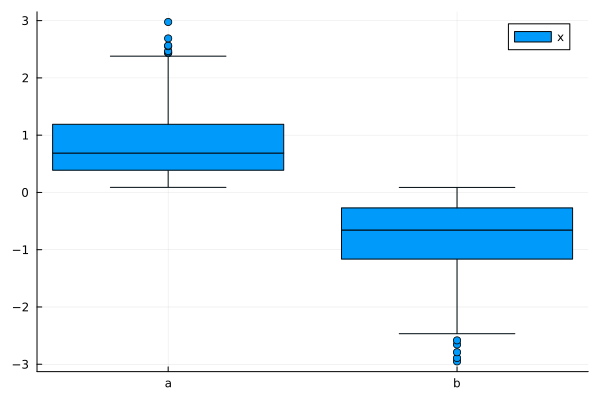

In [40]:
@df df boxplot(:z, :x, label="x")

a violin plot

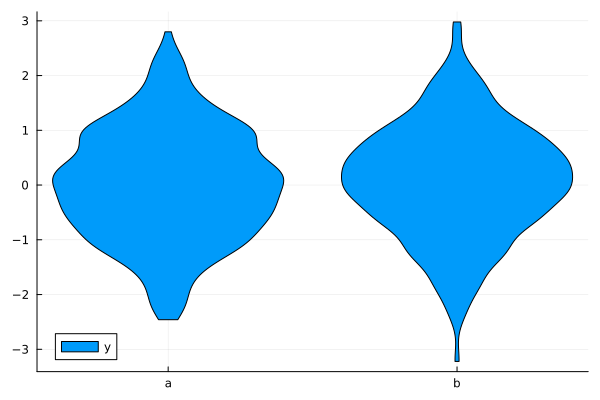

In [41]:
@df df violin(:z, :y, label="y")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*